# Loading the data

https://www.kaggle.com/datasets/jhoward/lsun_bedroom/data

@misc{yu2016lsun,
      title={LSUN: Construction of a Large-scale Image Dataset using Deep Learning with Humans in the Loop}, 
      author={Fisher Yu and Ari Seff and Yinda Zhang and Shuran Song and Thomas Funkhouser and Jianxiong Xiao},
      year={2016},
      eprint={1506.03365},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}

In [1]:
import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import v2

from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
#  data_path = './data/subset'
data_path = './data/data0/lsun/bedroom'

In [4]:
# image size after transformations
image_size = 64

resizer = v2.Resize((image_size, image_size))

simple_load = v2.Compose([
    resizer,
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize([0.5], [0.5]),
])

# Training the models

### DDPM

https://huggi64ace.co/docs/diffusers/en/tutorials/basic_training

In [5]:
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from diffusers.utils import make_image_grid
from datasets import load_dataset

In [ ]:
dataset = load_dataset(data_path, split='train')
dataset.set_transform(simple_load)

Resolving data files:   0%|          | 0/303125 [00:00<?, ?it/s]

In [13]:
def get_unet():
    unet_model = UNet2DModel(
        sample_size=image_size,  # the target image resolution
        in_channels=3,
        out_channels=3,
        layers_per_block=2,
        block_out_channels=(128, 128, 256, 256, 512, 512),
        down_block_types=(
            "DownBlock2D",  # a regular ResNet downsampling block
            "DownBlock2D",
            "DownBlock2D",
            "DownBlock2D",
            "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
            "DownBlock2D",
        ),
        up_block_types=(
            "UpBlock2D",  # a regular ResNet upsampling block
            "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",
            "UpBlock2D",
            "UpBlock2D",
            "UpBlock2D",
        ),
    ).to(device)
    return unet_model

In [14]:
def evaluate_ddpm(epoch, pipeline, save_name: str = 'ddpm_training', random_state: int | None = None):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=16,
        generator=torch.manual_seed(random_state),
    ).images

    image_grid = make_image_grid(images, rows=4, cols=4)
    test_dir = os.path.join('saved', save_name)
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [15]:
def train_unet(model, n_epochs: int, noise_scheduler, optimizer, dataset, batch_size: int = 16, start_epoch: int = 1,
               save_every: int = 1, save_name: str = 'ddpm_training'):
    data_loader = DataLoader(dataset, batch_size)

    for i in range(start_epoch - 1, n_epochs + start_epoch - 1):
        epoch_no = i + 1
        print(f'Starting epoch {epoch_no}...')

        for batch in tqdm(data_loader):
            clean_images = batch["image"].to(device)
            noise = torch.randn(clean_images.shape, device=device)
            bs = clean_images.shape[0]

            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=device,
                dtype=torch.int64
            )

            # Add noise to the clean images
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


        if epoch_no % save_every == 0:
            print(f'Evaluating after epoch {epoch_no}...')
            save_dir = f'saved/{save_name}'
            os.makedirs(save_dir, exist_ok=True)
            model.save_pretrained(f'{save_dir}/{epoch_no:04d}_model')
            # evaluate and save images
            pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
            evaluate_ddpm(epoch_no, pipeline, save_name, random_state=epoch_no)
        
        time.sleep(60 * 5)

In [16]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Testing learning rate $10^{-3}$ 

In [2]:
unet_model = get_unet()
train_unet(
    unet_model, 
    n_epochs=5, 
    noise_scheduler=noise_scheduler, 
    optimizer=optim.Adam(unet_model.parameters()), # default lr = 0.001
    dataset=dataset, 
    batch_size=16,
    save_every=1,
    save_name='ddpm_training_lr1e-3',
)

Testing learning rate $10^{-4}$ 

In [11]:
unet_model = get_unet()
train_unet(
    unet_model, 
    n_epochs=20, 
    noise_scheduler=noise_scheduler, 
    optimizer=optim.Adam(unet_model.parameters(), lr=0.0001), 
    dataset=dataset, 
    batch_size=16,
    save_every=1,
    save_name='ddpm_training_lr1e-4',
)

Starting epoch 1...


  0%|          | 84/18946 [00:44<2:46:44,  1.89it/s]

Testing learning rate $10^{-5}$ 

In [ ]:
unet_model = get_unet()
train_unet( 
    unet_model, 
    n_epochs=10, 
    noise_scheduler=noise_scheduler, 
    optimizer=optim.Adam(unet_model.parameters(), lr=1e-5), 
    dataset=dataset, 
    batch_size=16,
    save_every=1,
    save_name='ddpm_training_lr1e-5',
)

#### Testing regularisation

In [17]:
unet_model = get_unet()
train_unet(
    unet_model, 
    n_epochs=3, 
    noise_scheduler=noise_scheduler, 
    optimizer=optim.Adam(unet_model.parameters(), lr=1e-4, weight_decay=1e-4), 
    dataset=dataset, 
    batch_size=16,
    save_every=1,
    save_name='ddpm_training_reg1e-4',
)

Starting epoch 1...


100%|██████████| 18946/18946 [2:41:53<00:00,  1.95it/s]  


Evaluating after epoch 1...


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\macie\AppData\Local\Programs\Python\Python310\lib\site-packages\diffusers\utils\pil_utils.py:43: RuntimeWarning: invalid value encountered in cast
  images = (images * 255).round().astype("uint8")


Starting epoch 2...


100%|██████████| 18946/18946 [2:37:46<00:00,  2.00it/s]  


Evaluating after epoch 2...


  0%|          | 0/1000 [00:00<?, ?it/s]

Starting epoch 3...


100%|██████████| 18946/18946 [2:37:54<00:00,  2.00it/s]  


Evaluating after epoch 3...


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
unet_model = get_unet()
train_unet(
    unet_model, 
    n_epochs=3, 
    noise_scheduler=noise_scheduler, 
    optimizer=optim.Adam(unet_model.parameters(), lr=1e-4, weight_decay=1e-5), 
    dataset=dataset, 
    batch_size=16,
    save_every=1,
    save_name='ddpm_training_reg1e-5',
)

Starting epoch 1...


  0%|          | 84/18946 [00:44<2:46:44,  1.89it/s]

In [18]:
unet_model = get_unet()
train_unet(
    unet_model, 
    n_epochs=3, 
    noise_scheduler=noise_scheduler, 
    optimizer=optim.Adam(unet_model.parameters(), lr=1e-4, weight_decay=1e-6), 
    dataset=dataset, 
    batch_size=16,
    save_every=1,
    save_name='ddpm_training_reg1e-6',
)

Starting epoch 1...


100%|██████████| 18946/18946 [2:34:50<00:00,  2.04it/s]  


Evaluating after epoch 1...


  0%|          | 0/1000 [00:00<?, ?it/s]

Starting epoch 2...


100%|██████████| 18946/18946 [2:35:37<00:00,  2.03it/s]  


Evaluating after epoch 2...


  0%|          | 0/1000 [00:00<?, ?it/s]

Starting epoch 3...


100%|██████████| 18946/18946 [2:37:28<00:00,  2.01it/s]  


Evaluating after epoch 3...


  0%|          | 0/1000 [00:00<?, ?it/s]

Unfortunately using regularisation made all images all black

### GAN

In [6]:
from fastai.vision import *
from fastai.vision.gan import *
from fastai.vision.all import *
from fastai.losses import *
from fastai.metrics import *

In [7]:
def get_data(batch_size, path):
    class TorchVisionTransform(Transform):
        def __init__(self, tfms): self.tfms = tfms
        def encodes(self, img: PILImage): return self.tfms(img)
        
    dblock = DataBlock(
        blocks=(ImageBlock),
        get_items=get_image_files,
        splitter=FuncSplitter(lambda x: False),
        item_tfms=TorchVisionTransform(simple_load)
    )
    
    dls = dblock.dataloaders(path, bs=batch_size) 
    return dls

In [8]:
batch_size = 16
dls = get_data(batch_size, data_path)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.network(input)


In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.network(input)

In [11]:
def evaluate_gan(epoch, generator, save_name: str = 'gan_training'):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    noise = torch.randn(16, 100, 1, 1, device=device)

    batch = generator(noise)
    pil_images = []
    for tensor in batch:
        tensor = tensor.permute(1, 2, 0)
        tensor = (tensor * 0.5) + 0.5 #denormalize
        tensor = (tensor * 255).byte()
        pil_image = Image.fromarray(tensor.to('cpu').numpy())
        pil_images.append(pil_image)
    image_grid = make_image_grid(pil_images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join('saved', save_name)
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [12]:
def train_gan(generator, discriminator, dls, opt_gen, opt_disc, n_epochs, 
              start_epoch: int = 1, save_every: int = 1, save_name: str = 'gan_training'):
    generator.train()
    discriminator.train()
    
    criterion = nn.BCEWithLogitsLoss()
    
    for i in range(start_epoch - 1, n_epochs + start_epoch - 1):
        epoch_no = i + 1

        for real in tqdm(dls[0]):
            real = real[0]
            real = real.to(device)
            batch_size = real.size(0)
            
            # Train discriminator
            opt_disc.zero_grad()
            noise = torch.randn(batch_size, 100, 1, 1, device=device)

            fake = generator(noise)
            disc_real = discriminator(real)
            disc_fake = discriminator(fake.detach())
            loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
            loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            loss_disc = (loss_disc_real + loss_disc_fake) / 2
            loss_disc.backward()
            opt_disc.step()
            
            # Train generator
            opt_gen.zero_grad()
            disc_fake = discriminator(fake)
            loss_gen = criterion(disc_fake, torch.ones_like(disc_fake))
            loss_gen.backward()
            opt_gen.step()
        
        print(f"Epoch {epoch_no} done! Loss discriminator: {loss_disc.item():.4f}, Loss generator: {loss_gen.item():.4f}")
        if epoch_no % save_every == 0:
            print(f'Evaluating after epoch {epoch_no}...')

            save_dir = f'saved/{save_name}'
            model_save_dir = f'{save_dir}/{epoch_no:04d}_model'
            os.makedirs(model_save_dir, exist_ok=True)

            generator_path = os.path.join(model_save_dir, 'generator.pth')
            discriminator_path = os.path.join(model_save_dir, 'discriminator.pth')
            torch.save(generator.state_dict(), generator_path)
            torch.save(discriminator.state_dict(), discriminator_path)
            
            evaluate_gan(epoch_no, generator, save_name)


In [13]:
def load_gan(path):
    generator = Generator().to(device)
    generator.load_state_dict(torch.load(f"{path}/generator.pth", map_location=torch.device(device)))

    discriminator = Discriminator().to(device)
    discriminator.load_state_dict(torch.load(f"{path}/discriminator.pth", map_location=torch.device(device)))
    
    return generator, discriminator

Testing learning rate $10^{-3}$ 

In [15]:
model_generator = Generator().to(device)
model_discriminator = Discriminator().to(device)

opt_gen = optim.Adam(model_generator.parameters(), lr=0.001)
opt_disc = optim.Adam(model_discriminator.parameters(), lr=0.001)

train_gan(model_generator, model_discriminator, dls, opt_gen, opt_disc, n_epochs=10, save_name = 'gan_training_lr1e-3')

100%|██████████| 18945/18945 [19:44<00:00, 15.99it/s]


Epoch 1 done! Loss discriminator: 0.8133, Loss generator: 0.3133
Evaluating after epoch 1...


100%|██████████| 18945/18945 [19:43<00:00, 16.01it/s] 


Epoch 2 done! Loss discriminator: 0.8133, Loss generator: 0.3133
Evaluating after epoch 2...


100%|██████████| 18945/18945 [19:18<00:00, 16.35it/s]


Epoch 3 done! Loss discriminator: 0.8133, Loss generator: 0.3133
Evaluating after epoch 3...


100%|██████████| 18945/18945 [19:35<00:00, 16.12it/s] 


Epoch 4 done! Loss discriminator: 0.8133, Loss generator: 0.3133
Evaluating after epoch 4...


100%|██████████| 18945/18945 [19:53<00:00, 15.87it/s]


Epoch 5 done! Loss discriminator: 0.8133, Loss generator: 0.3133
Evaluating after epoch 5...


100%|██████████| 18945/18945 [19:32<00:00, 16.16it/s]  


Epoch 6 done! Loss discriminator: 0.8133, Loss generator: 0.3133
Evaluating after epoch 6...


100%|██████████| 18945/18945 [19:19<00:00, 16.33it/s]


Epoch 7 done! Loss discriminator: 0.8133, Loss generator: 0.3133
Evaluating after epoch 7...


100%|██████████| 18945/18945 [19:37<00:00, 16.09it/s]


Epoch 8 done! Loss discriminator: 0.8133, Loss generator: 0.3133
Evaluating after epoch 8...


100%|██████████| 18945/18945 [19:34<00:00, 16.12it/s] 


Epoch 9 done! Loss discriminator: 0.8133, Loss generator: 0.3133
Evaluating after epoch 9...


100%|██████████| 18945/18945 [19:27<00:00, 16.23it/s] 


Epoch 10 done! Loss discriminator: 0.8133, Loss generator: 0.3133
Evaluating after epoch 10...


Testing learning rate $10^{-4}$ 

In [16]:
model_generator = Generator().to(device)
model_discriminator = Discriminator().to(device)

opt_gen = optim.Adam(model_generator.parameters(), lr=1e-4)
opt_disc = optim.Adam(model_discriminator.parameters(), lr=1e-4)

train_gan(model_generator, model_discriminator, dls, opt_gen, opt_disc, n_epochs=10, save_name = 'gan_training_lr1e-4')

100%|██████████| 18945/18945 [19:06<00:00, 16.52it/s] 


Epoch 1 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 1...


100%|██████████| 18945/18945 [19:17<00:00, 16.36it/s] 


Epoch 2 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 2...


100%|██████████| 18945/18945 [19:35<00:00, 16.11it/s] 


Epoch 3 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 3...


100%|██████████| 18945/18945 [19:57<00:00, 15.82it/s] 


Epoch 4 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 4...


100%|██████████| 18945/18945 [19:09<00:00, 16.48it/s] 


Epoch 5 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 5...


100%|██████████| 18945/18945 [19:20<00:00, 16.33it/s] 


Epoch 6 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 6...


100%|██████████| 18945/18945 [19:10<00:00, 16.46it/s] 


Epoch 7 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 7...


100%|██████████| 18945/18945 [19:04<00:00, 16.55it/s] 


Epoch 8 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 8...


100%|██████████| 18945/18945 [19:17<00:00, 16.36it/s] 


Epoch 9 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 9...


100%|██████████| 18945/18945 [19:11<00:00, 16.45it/s] 


Epoch 10 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 10...


Testing learning rate $10^{-5}$ 

In [16]:
model_generator = Generator().to(device)
model_discriminator = Discriminator().to(device)

opt_gen = optim.Adam(model_generator.parameters(), lr=1e-5)
opt_disc = optim.Adam(model_discriminator.parameters(), lr=1e-5)

train_gan(model_generator, model_discriminator, dls, opt_gen, opt_disc, n_epochs=20, save_name = 'gan_training_lr1e-5')

100%|██████████| 18945/18945 [20:23<00:00, 15.49it/s]


Epoch 12 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 12...


100%|██████████| 18945/18945 [19:26<00:00, 16.25it/s] 


Epoch 13 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 13...


100%|██████████| 18945/18945 [19:26<00:00, 16.24it/s] 


Epoch 14 done! Loss discriminator: 0.5034, Loss generator: 0.6928
Evaluating after epoch 14...


100%|██████████| 18945/18945 [19:32<00:00, 16.16it/s] 


Epoch 15 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 15...


100%|██████████| 18945/18945 [19:36<00:00, 16.11it/s] 


Epoch 16 done! Loss discriminator: 0.5033, Loss generator: 0.6931
Evaluating after epoch 16...


100%|██████████| 18945/18945 [19:24<00:00, 16.28it/s] 


Epoch 17 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 17...


100%|██████████| 18945/18945 [19:37<00:00, 16.09it/s] 


Epoch 18 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 18...


100%|██████████| 18945/18945 [19:48<00:00, 15.94it/s] 


Epoch 19 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 19...


100%|██████████| 18945/18945 [19:28<00:00, 16.22it/s]


Epoch 20 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 20...


100%|██████████| 18945/18945 [19:23<00:00, 16.28it/s] 


Epoch 21 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 21...


### Testing regularisation

In [14]:
model_generator = Generator().to(device)
model_discriminator = Discriminator().to(device)

opt_gen = optim.Adam(model_generator.parameters(), lr=1e-5, weight_decay=1e-3)
opt_disc = optim.Adam(model_discriminator.parameters(), lr=1e-5, weight_decay=1e-3)

train_gan(model_generator, model_discriminator, dls, opt_gen, opt_disc, n_epochs=5, save_name = 'gan_training_reg_1e-3')

In [15]:
model_generator = Generator().to(device)
model_discriminator = Discriminator().to(device)

opt_gen = optim.Adam(model_generator.parameters(), lr=1e-5, weight_decay=1e-4)
opt_disc = optim.Adam(model_discriminator.parameters(), lr=1e-5, weight_decay=1e-4)

train_gan(model_generator, model_discriminator, dls, opt_gen, opt_disc, n_epochs=5, save_name = 'gan_training_reg_1e-4')

100%|██████████| 18945/18945 [19:16<00:00, 16.39it/s]


Epoch 1 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 1...


100%|██████████| 18945/18945 [18:58<00:00, 16.65it/s]


Epoch 2 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 2...


100%|██████████| 18945/18945 [19:38<00:00, 16.07it/s] 


Epoch 3 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 3...


100%|██████████| 18945/18945 [19:13<00:00, 16.42it/s]


Epoch 4 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 4...


100%|██████████| 18945/18945 [19:02<00:00, 16.59it/s]

Epoch 5 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 5...


In [16]:
model_generator = Generator().to(device)
model_discriminator = Discriminator().to(device)

opt_gen = optim.Adam(model_generator.parameters(), lr=1e-5, weight_decay=1e-5)
opt_disc = optim.Adam(model_discriminator.parameters(), lr=1e-5, weight_decay=1e-5)

train_gan(model_generator, model_discriminator, dls, opt_gen, opt_disc, n_epochs=5, save_name = 'gan_training_reg_1e-5')

100%|██████████| 18945/18945 [18:53<00:00, 16.72it/s]


Epoch 1 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 1...


100%|██████████| 18945/18945 [19:23<00:00, 16.28it/s]  


Epoch 2 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 2...


100%|██████████| 18945/18945 [18:48<00:00, 16.79it/s]  


Epoch 3 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 3...


100%|██████████| 18945/18945 [19:27<00:00, 16.23it/s]  


Epoch 4 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 4...


100%|██████████| 18945/18945 [19:27<00:00, 16.23it/s]

Epoch 5 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 5...


In [17]:
model_generator = Generator().to(device)
model_discriminator = Discriminator().to(device)

opt_gen = optim.Adam(model_generator.parameters(), lr=1e-5, weight_decay=1e-6)
opt_disc = optim.Adam(model_discriminator.parameters(), lr=1e-5, weight_decay=1e-6)

train_gan(model_generator, model_discriminator, dls, opt_gen, opt_disc, n_epochs=10, save_name = 'gan_training_reg_1e-6')

100%|██████████| 18945/18945 [19:47<00:00, 15.96it/s]  


Epoch 1 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 1...


100%|██████████| 18945/18945 [19:15<00:00, 16.40it/s] 


Epoch 2 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 2...


100%|██████████| 18945/18945 [19:43<00:00, 16.01it/s] 


Epoch 3 done! Loss discriminator: 0.5035, Loss generator: 0.6929
Evaluating after epoch 3...


100%|██████████| 18945/18945 [19:55<00:00, 15.85it/s]


Epoch 4 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 4...


100%|██████████| 18945/18945 [19:40<00:00, 16.05it/s]  


Epoch 5 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 5...


### Testing batch-size

In [18]:
batch_size = 4
dls = get_data(batch_size, data_path)

model_generator = Generator().to(device)
model_discriminator = Discriminator().to(device)

opt_gen = optim.Adam(model_generator.parameters(), lr=1e-5)
opt_disc = optim.Adam(model_discriminator.parameters(), lr=1e-5)

train_gan(model_generator, model_discriminator, dls, opt_gen, opt_disc, n_epochs=20, save_name = 'gan_training_batch-size_4')

100%|██████████| 75781/75781 [32:11<00:00, 39.24it/s]  


Epoch 1 done! Loss discriminator: 0.5038, Loss generator: 0.6921
Evaluating after epoch 1...


100%|██████████| 75781/75781 [33:06<00:00, 38.14it/s]  


Epoch 2 done! Loss discriminator: 0.5221, Loss generator: 0.6931
Evaluating after epoch 2...


100%|██████████| 75781/75781 [32:50<00:00, 38.46it/s]  


Epoch 3 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 3...


100%|██████████| 75781/75781 [33:28<00:00, 37.74it/s]  


Epoch 4 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 4...


100%|██████████| 75781/75781 [32:52<00:00, 38.42it/s]  


Epoch 5 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 5...


100%|██████████| 75781/75781 [32:53<00:00, 38.40it/s]  


Epoch 6 done! Loss discriminator: 0.5033, Loss generator: 0.6931
Evaluating after epoch 6...


100%|██████████| 75781/75781 [32:51<00:00, 38.43it/s]  


Epoch 7 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 7...


100%|██████████| 75781/75781 [32:51<00:00, 38.44it/s]  


Epoch 8 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 8...


100%|██████████| 75781/75781 [32:51<00:00, 38.44it/s] 


Epoch 9 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 9...


100%|██████████| 75781/75781 [32:49<00:00, 38.49it/s]  

Epoch 10 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 10...


In [14]:
batch_size = 8
dls = get_data(batch_size, data_path)

model_generator = Generator().to(device)
model_discriminator = Discriminator().to(device)

opt_gen = optim.Adam(model_generator.parameters(), lr=1e-5)
opt_disc = optim.Adam(model_discriminator.parameters(), lr=1e-5)

train_gan(model_generator, model_discriminator, dls, opt_gen, opt_disc, n_epochs=20, save_name = 'gan_training_batch-size_8')

100%|██████████| 37890/37890 [23:54<00:00, 26.41it/s]


Epoch 8 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 8...


100%|██████████| 37890/37890 [23:56<00:00, 26.38it/s] 


Epoch 9 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 9...


100%|██████████| 37890/37890 [23:34<00:00, 26.79it/s]


Epoch 10 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 10...


In [15]:
batch_size = 32
dls = get_data(batch_size, data_path)

model_generator = Generator().to(device)
model_discriminator = Discriminator().to(device)

opt_gen = optim.Adam(model_generator.parameters(), lr=1e-5)
opt_disc = optim.Adam(model_discriminator.parameters(), lr=1e-5)

train_gan(model_generator, model_discriminator, dls, opt_gen, opt_disc, n_epochs=10, save_name = 'gan_training_batch-size_32')

100%|██████████| 9472/9472 [17:35<00:00,  8.97it/s]


Epoch 1 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 1...


100%|██████████| 9472/9472 [17:24<00:00,  9.07it/s]


Epoch 2 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 2...


100%|██████████| 9472/9472 [17:35<00:00,  8.97it/s]


Epoch 3 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 3...


100%|██████████| 9472/9472 [17:26<00:00,  9.05it/s]


Epoch 4 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 4...


100%|██████████| 9472/9472 [17:38<00:00,  8.95it/s]


Epoch 5 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 5...


100%|██████████| 9472/9472 [18:24<00:00,  8.57it/s]  


Epoch 6 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 6...


100%|██████████| 9472/9472 [17:35<00:00,  8.97it/s] 


Epoch 7 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 7...


100%|██████████| 9472/9472 [17:46<00:00,  8.88it/s]


Epoch 8 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 8...


100%|██████████| 9472/9472 [18:11<00:00,  8.68it/s] 


Epoch 9 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 9...


100%|██████████| 9472/9472 [17:48<00:00,  8.86it/s]


Epoch 10 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 10...


In [16]:
batch_size = 64
dls = get_data(batch_size, data_path)

model_generator = Generator().to(device)
model_discriminator = Discriminator().to(device)

opt_gen = optim.Adam(model_generator.parameters(), lr=1e-5)
opt_disc = optim.Adam(model_discriminator.parameters(), lr=1e-5)

train_gan(model_generator, model_discriminator, dls, opt_gen, opt_disc, n_epochs=10, save_name = 'gan_training_batch-size_64')

100%|██████████| 4736/4736 [16:34<00:00,  4.76it/s] 


Epoch 1 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 1...


100%|██████████| 4736/4736 [16:26<00:00,  4.80it/s]


Epoch 2 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 2...


100%|██████████| 4736/4736 [16:25<00:00,  4.81it/s]


Epoch 3 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 3...


100%|██████████| 4736/4736 [16:26<00:00,  4.80it/s]


Epoch 4 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 4...


100%|██████████| 4736/4736 [16:27<00:00,  4.79it/s]


Epoch 5 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 5...


100%|██████████| 4736/4736 [16:26<00:00,  4.80it/s]


Epoch 6 done! Loss discriminator: 0.5035, Loss generator: 0.6927
Evaluating after epoch 6...


100%|██████████| 4736/4736 [16:55<00:00,  4.67it/s]


Epoch 7 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 7...


100%|██████████| 4736/4736 [16:33<00:00,  4.77it/s]


Epoch 8 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 8...


100%|██████████| 4736/4736 [16:59<00:00,  4.65it/s]


Epoch 9 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 9...


100%|██████████| 4736/4736 [17:06<00:00,  4.62it/s]


Epoch 10 done! Loss discriminator: 0.5034, Loss generator: 0.6929
Evaluating after epoch 10...


Best results achieved with batch size=16

### Testing beta1 value

In [ ]:
batch_size = 16
dls = get_data(batch_size, data_path)

model_generator = Generator().to(device)
model_discriminator = Discriminator().to(device)

opt_gen = optim.Adam(model_generator.parameters(), lr=1e-5, betas=(0.5, 0.999))
opt_disc = optim.Adam(model_discriminator.parameters(), lr=1e-5, betas=(0.5, 0.999))

train_gan(model_generator, model_discriminator, dls, opt_gen, opt_disc, n_epochs=15, save_name = 'gan_training_beta1=0.5')

## Final training

In [19]:
batch_size = 16
dls = get_data(batch_size, data_path)

In [ ]:
model_generator, model_discriminator = load_gan('saved/gan_training_lr1e-5/0020_model')

opt_gen = optim.Adam(model_generator.parameters(), lr=1e-5)
opt_disc = optim.Adam(model_discriminator.parameters(), lr=1e-5)

train_gan(model_generator, model_discriminator, dls, opt_gen, opt_disc, start_epoch=21, n_epochs=50, save_name = 'gan_training_final')

In [20]:
model_generator, model_discriminator = load_gan('saved/gan_training_final/0041_model')

opt_gen = optim.Adam(model_generator.parameters(), lr=1e-6)
opt_disc = optim.Adam(model_discriminator.parameters(), lr=1e-6)

train_gan(model_generator, model_discriminator, dls, opt_gen, opt_disc, start_epoch=42, n_epochs=29, save_name = 'gan_training_final_part2')

100%|██████████| 18945/18945 [20:45<00:00, 15.21it/s] 


Epoch 42 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 42...


100%|██████████| 18945/18945 [19:37<00:00, 16.09it/s] 


Epoch 43 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 43...


100%|██████████| 18945/18945 [19:35<00:00, 16.12it/s]


Epoch 44 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 44...


100%|██████████| 18945/18945 [19:53<00:00, 15.87it/s]


Epoch 45 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 45...


100%|██████████| 18945/18945 [19:54<00:00, 15.86it/s] 


Epoch 46 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 46...


100%|██████████| 18945/18945 [19:53<00:00, 15.88it/s] 


Epoch 47 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 47...


100%|██████████| 18945/18945 [19:48<00:00, 15.94it/s]  


Epoch 48 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 48...


100%|██████████| 18945/18945 [19:56<00:00, 15.84it/s] 


Epoch 49 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 49...


100%|██████████| 18945/18945 [20:01<00:00, 15.77it/s] 


Epoch 50 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 50...


100%|██████████| 18945/18945 [19:41<00:00, 16.04it/s] 


Epoch 51 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 51...


100%|██████████| 18945/18945 [19:41<00:00, 16.03it/s] 


Epoch 52 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 52...


100%|██████████| 18945/18945 [19:36<00:00, 16.11it/s] 


Epoch 53 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 53...


100%|██████████| 18945/18945 [19:15<00:00, 16.40it/s] 


Epoch 54 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 54...


100%|██████████| 18945/18945 [19:17<00:00, 16.37it/s] 


Epoch 55 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 55...


100%|██████████| 18945/18945 [19:46<00:00, 15.96it/s] 


Epoch 56 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 56...


100%|██████████| 18945/18945 [19:33<00:00, 16.15it/s]


Epoch 57 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 57...


100%|██████████| 18945/18945 [19:11<00:00, 16.45it/s]


Epoch 58 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 58...


100%|██████████| 18945/18945 [19:38<00:00, 16.08it/s]


Epoch 59 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 59...


100%|██████████| 18945/18945 [19:30<00:00, 16.19it/s]


Epoch 60 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 60...


100%|██████████| 18945/18945 [19:29<00:00, 16.20it/s]  


Epoch 61 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 61...


100%|██████████| 18945/18945 [19:27<00:00, 16.23it/s]


Epoch 62 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 62...


100%|██████████| 18945/18945 [19:44<00:00, 16.00it/s]  


Epoch 63 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 63...


100%|██████████| 18945/18945 [19:44<00:00, 15.99it/s] 


Epoch 64 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 64...


100%|██████████| 18945/18945 [19:31<00:00, 16.17it/s] 


Epoch 65 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 65...


100%|██████████| 18945/18945 [19:39<00:00, 16.07it/s] 


Epoch 66 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 66...


100%|██████████| 18945/18945 [20:14<00:00, 15.59it/s]


Epoch 67 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 67...


100%|██████████| 18945/18945 [19:52<00:00, 15.88it/s]  


Epoch 68 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 68...


100%|██████████| 18945/18945 [19:47<00:00, 15.95it/s]  


Epoch 69 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 69...


100%|██████████| 18945/18945 [19:42<00:00, 16.02it/s]  


Epoch 70 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 70...


In [22]:
model_generator, model_discriminator = load_gan('saved/gan_training_final/0041_model')

opt_gen = optim.Adam(model_generator.parameters(), lr=1e-7)
opt_disc = optim.Adam(model_discriminator.parameters(), lr=1e-7)

train_gan(model_generator, model_discriminator, dls, opt_gen, opt_disc, start_epoch=42, n_epochs=29, save_name = 'gan_training_final_part3')

100%|██████████| 18945/18945 [19:59<00:00, 15.80it/s]


Epoch 42 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 42...


100%|██████████| 18945/18945 [19:38<00:00, 16.08it/s] 


Epoch 43 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 43...


100%|██████████| 18945/18945 [19:37<00:00, 16.09it/s] 


Epoch 44 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 44...


100%|██████████| 18945/18945 [19:54<00:00, 15.86it/s]


Epoch 45 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 45...


100%|██████████| 18945/18945 [19:43<00:00, 16.00it/s]


Epoch 46 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 46...


100%|██████████| 18945/18945 [19:41<00:00, 16.03it/s]


Epoch 47 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 47...


100%|██████████| 18945/18945 [19:44<00:00, 15.99it/s]


Epoch 48 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 48...


100%|██████████| 18945/18945 [19:43<00:00, 16.01it/s]


Epoch 49 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 49...


100%|██████████| 18945/18945 [19:43<00:00, 16.01it/s]


Epoch 50 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 50...


100%|██████████| 18945/18945 [19:42<00:00, 16.03it/s]


Epoch 51 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 51...


100%|██████████| 18945/18945 [19:45<00:00, 15.97it/s]


Epoch 52 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 52...


100%|██████████| 18945/18945 [19:46<00:00, 15.97it/s]  


Epoch 53 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 53...


100%|██████████| 18945/18945 [19:55<00:00, 15.84it/s]  


Epoch 54 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 54...


100%|██████████| 18945/18945 [19:41<00:00, 16.04it/s] 


Epoch 55 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 55...


100%|██████████| 18945/18945 [19:43<00:00, 16.00it/s] 


Epoch 56 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 56...


100%|██████████| 18945/18945 [19:56<00:00, 15.83it/s] 


Epoch 57 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 57...


100%|██████████| 18945/18945 [19:44<00:00, 16.00it/s]


Epoch 58 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 58...


100%|██████████| 18945/18945 [19:42<00:00, 16.02it/s]


Epoch 59 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 59...


100%|██████████| 18945/18945 [19:42<00:00, 16.02it/s]


Epoch 60 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 60...


100%|██████████| 18945/18945 [19:45<00:00, 15.99it/s]  


Epoch 61 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 61...


100%|██████████| 18945/18945 [19:46<00:00, 15.97it/s]  


Epoch 62 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 62...


100%|██████████| 18945/18945 [19:51<00:00, 15.91it/s] 


Epoch 63 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 63...


100%|██████████| 18945/18945 [20:00<00:00, 15.78it/s]


Epoch 64 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 64...


100%|██████████| 18945/18945 [19:44<00:00, 16.00it/s]  


Epoch 65 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 65...


100%|██████████| 18945/18945 [19:47<00:00, 15.96it/s]  


Epoch 66 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 66...


100%|██████████| 18945/18945 [19:51<00:00, 15.90it/s] 


Epoch 67 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 67...


100%|██████████| 18945/18945 [19:59<00:00, 15.80it/s] 


Epoch 68 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 68...


100%|██████████| 18945/18945 [19:48<00:00, 15.93it/s]  


Epoch 69 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 69...


100%|██████████| 18945/18945 [19:49<00:00, 15.93it/s]  

Epoch 70 done! Loss discriminator: 0.5032, Loss generator: 0.6931
Evaluating after epoch 70...


# Evaluating the best models
We use Frechet Inception Distance

In [14]:
import os

from PIL import Image
from torchvision.utils import save_image
from pytorch_fid import fid_score

In [15]:
def make_subset_real(num_images: int):
    """
    Generate a subset of real images for evaluation with FID. 
    Returns a path to folder with these images
    """
    dest_dir = 'data/subset_fid'
    os.makedirs(dest_dir, exist_ok=True)

    saved_imgs = 0
    
    for root, dirs, files in os.walk(data_path):
        if files:
            for img in files:
                src_path = os.path.join(root, img)
                dst_path = os.path.join(dest_dir, img)

                # resize the image
                with Image.open(src_path) as image:
                    image = resizer(image)
                    image.save(dst_path)
                    
                saved_imgs += 1
                if saved_imgs == num_images:
                    return dest_dir

    return dest_dir

In [16]:
def generate_images(generator: nn.Module, num_images: int, save_name: str):
    """
    Generate images using given generator. 
    Returns a path to folder with generated images
    """
    
    generator.eval()

    # generate images
    noise = torch.randn(num_images, 100, 1, 1, device=device)

    with torch.no_grad():
        batch = generator(noise)

    # Rescale images from [-1, 1] to [0, 1]
    batch = (batch + 1) / 2

    # Save generated images
    path = f'saved/generated/{save_name}'
    os.makedirs(path, exist_ok=True)
    for i, img in enumerate(batch):
        save_image(img, os.path.join(path, f"{i:05d}.png"))

    return path

Generate subset of data for FID

In [17]:
num_images = 10000
path_subset_fid = make_subset_real(num_images)

Pick the best models to evaluate

In [18]:
final_generators = {
    'generator41': load_gan('saved/gan_training_final/0041_model')[0],
    'generator43_pt3': load_gan('saved/gan_training_final_part3/0043_model')[0],
    'generator45_pt3': load_gan('saved/gan_training_final_part3/0045_model')[0],
    'generator47_pt2': load_gan('saved/gan_training_final_part2/0047_model')[0],
}

In [19]:
final_results = pd.DataFrame(columns=['generator', 'FID'])

for generator_name, generator in final_generators.items():
    print(f'Evaluating {generator_name}...')

    path_generated = generate_images(generator, num_images, generator_name)
    fid_value = fid_score.calculate_fid_given_paths([path_subset_fid, path_generated], batch_size=16, device=device, dims=2048)
    
    final_results.loc[len(final_results)] = [generator_name, fid_value]

Evaluating generator41...


100%|██████████| 625/625 [01:19<00:00,  7.82it/s]


Evaluating generator43_pt3...


100%|██████████| 625/625 [01:18<00:00,  7.93it/s]


Evaluating generator45_pt3...


100%|██████████| 625/625 [01:15<00:00,  8.31it/s]


Evaluating generator47_pt2...


100%|██████████| 625/625 [01:15<00:00,  8.33it/s]


In [20]:
final_results

,generator,FID
0,generator41,213.546506
1,generator43_pt3,210.999851
2,generator45_pt3,202.652515
3,generator47_pt2,220.804244


In [21]:
best_generator = final_generators['generator45_pt3']

# Example photo

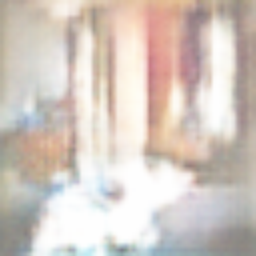

In [43]:
torch.manual_seed(19)

noise = torch.randn(1, 100, 1, 1, device=device)
tensor = best_generator(noise)[0]
tensor = tensor.permute(1, 2, 0)
tensor = (tensor * 0.5) + 0.5 #denormalize
tensor = (tensor * 255).byte()

pil_image = Image.fromarray(tensor.to('cpu').numpy())
pil_image = v2.Resize((64*4, 64*4))(pil_image)
pil_image

# Experimenting with latent noise matrices

In [85]:
torch.manual_seed(28)
noise1 = torch.randn(1, 100, 1, 1, device=device)
noise2 = torch.randn(1, 100, 1, 1, device=device)

In [86]:
noises_interpolated = []
for a in np.linspace(0.0, 1.0, 10):
    new_noise = a * noise1 + (1-a) * noise2
    noises_interpolated.append(new_noise)

In [87]:
pil_images = []
for noise in noises_interpolated:
    tensor = best_generator(noise)[0]
    tensor = tensor.permute(1, 2, 0)
    tensor = (tensor * 0.5) + 0.5 #denormalize
    tensor = (tensor * 255).byte()
    pil_image = Image.fromarray(tensor.to('cpu').numpy())
    pil_images.append(pil_image)

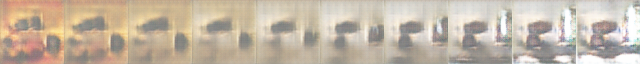

In [88]:
image_grid = make_image_grid(pil_images, rows=1, cols=10)
image_grid

In [94]:
image_grid.save('saved/latent_matrix_interpolate.png')

All results are discussed in the report